# Mount Google Drive

In [1]:
import os
import glob
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Carvana_UNet"

12_tests  model_unet_checkpoint.h5  train  train_masks	UNet.ipynb


In [5]:
ROOT = '/content/drive/My Drive/Colab Notebooks/Carvana_UNet'
TRAIN_DIR = 'train'
MASK_DIR = 'train_masks'

X_root,_,X_files = next(os.walk(os.path.join(ROOT, TRAIN_DIR)))
y_root,_,y_files = next(os.walk(os.path.join(ROOT, MASK_DIR)))

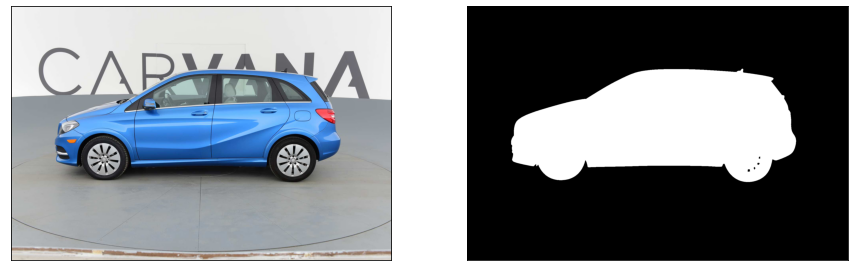

In [ ]:
TRAIN_SIZE = 1000
train_files = [os.path.join(X_root, f) for f in X_files][:TRAIN_SIZE]
mask_files = [os.path.join(y_root, os.path.splitext(f)[0] + '_mask.gif') for f in X_files][:TRAIN_SIZE]

plt.figure(figsize=(15, 10))
for i, path in enumerate([train_files[0], mask_files[0]]):
  plt.subplot(1, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = plt.imread(path)
  plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
from tqdm import tqdm

IMG_HEIGHT = 320
IMG_WIDTH = 480
IMG_CHANNELS = 3

X_train = np.zeros((len(train_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
from PIL import Image

for i, (img_path, mask_path) in tqdm(enumerate(zip(train_files, mask_files)), total=len(train_files)):
  
  img = Image.open(img_path)
  img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  img_arr = np.asarray(img)

  X_train[i] = img_arr

  mask = Image.open(mask_path)
  mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
  mask_arr = np.asarray(mask)
  mask_arr = np.expand_dims(mask_arr, axis=2)  # reshape to (h, w, 1)

  Y_train[i] = mask_arr

#Create a UNet Model

![](https://drive.google.com/uc?id=1tRvTdQ5eTAl-0vZz2Q4TUs8L2LmRt6pt)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, concatenate

In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)

c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [ ]:
from tensorflow.keras.models import Model

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 320, 480, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 320, 480, 32) 896         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 320, 480, 32) 128         conv2d_38[0][0]                  
____________________________________________________________________________________________

# Make an initial prediction

1/1 [==============================] - 0s 403ms/step


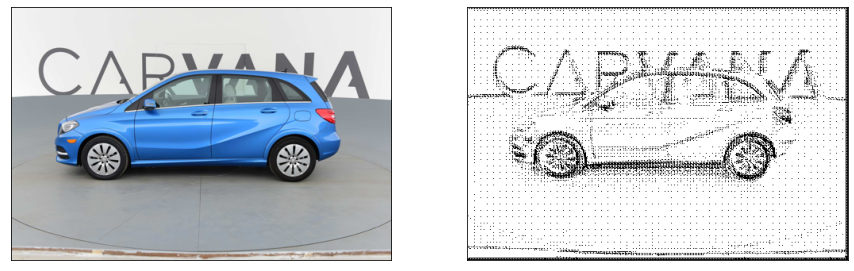

In [ ]:
pred = model.predict(X_train[:1], verbose=1)
pred_mask = np.where(pred >= 0.5, 255, 0)
pred_mask = np.repeat(pred_mask, 3, axis=3)

fig = plt.figure(figsize=(15, 10))
for i, img in enumerate([X_train, pred_mask]):
  plt.subplot(1, 2, i+1)
  plt.imshow(img[0])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

# Model training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(ROOT, 'model_unet_checkpoint.h5'), verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/100
57/57 [==============================] - 54s 833ms/step - loss: 0.2977 - accuracy: 0.8946 - val_loss: 1.1902 - val_accuracy: 0.7983

Epoch 00001: val_loss improved from inf to 1.19020, saving model to /content/drive/My Drive/Colab Notebooks/Carvana_UNet/model_unet_checkpoint.h5
Epoch 2/100
57/57 [==============================] - 44s 772ms/step - loss: 0.0501 - accuracy: 0.9863 - val_loss: 1.1520 - val_accuracy: 0.8364

Epoch 00002: val_loss improved from 1.19020 to 1.15204, saving model to /content/drive/My Drive/Colab Notebooks/Carvana_UNet/model_unet_checkpoint.h5
Epoch 3/100
57/57 [==============================] - 44s 781ms/step - loss: 0.0295 - accuracy: 0.9916 - val_loss: 0.9239 - val_accuracy: 0.8636

Epoch 00003: val_loss improved from 1.15204 to 0.92393, saving model to /content/drive/My Drive/Colab Notebooks/Carvana_UNet/model_unet_checkpoint.h5
Epoch 4/100
57/57 [==============================] - 44s 778ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.887

In [ ]:
while True:pass

# Predict training set

In [ ]:
NUM_SAMPLES = 3
inds = np.random.choice(X_train.shape[0], NUM_SAMPLES, replace=False)
X_test = X_train[inds]
pred = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 68ms/step


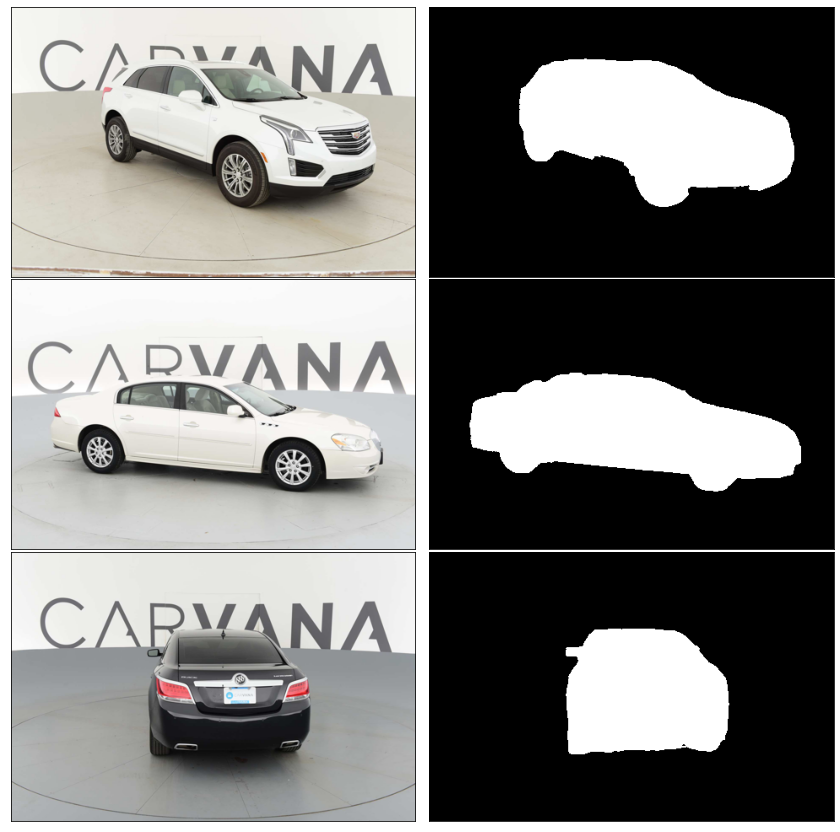

In [ ]:
pred_mask = np.where(pred >= 0.5, 255, 0)
pred_mask = np.repeat(pred_mask, 3, axis=3)

fig = plt.figure(figsize=(15, 25))
fig.subplots_adjust(wspace=0, hspace=0.01)
for i, (img, mask) in enumerate(zip(X_test, pred_mask)):
  plt.subplot(NUM_SAMPLES, 2, 2*i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.subplot(NUM_SAMPLES, 2, 2*i+2)
  plt.imshow(mask)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

# Predict test set

In [11]:
import numpy as np
from PIL import Image

TEST_ROOT = 'test_12'

_,_,pred_files = next(os.walk(os.path.join(ROOT, TEST_ROOT)))
X_test = np.zeros((len(pred_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, img_path in enumerate(pred_files): 
  img = Image.open(os.path.join(ROOT, TEST_ROOT, img_path))
  img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  img_arr = np.asarray(img)
  X_test[i] = img_arr

In [13]:
import keras

model_path = '/content/drive/MyDrive/Colab Notebooks/Carvana_UNet/model_unet_checkpoint.h5'
model = keras.models.load_model(model_path)
Y_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 7s 7s/step


In [14]:
pred_mask = np.where(Y_test >= 0.5, 255, 0)
pred_mask = np.repeat(pred_mask, 3, axis=3)

ROWS = Y_test.shape[0]
fig = plt.figure(figsize=(15, 5 * ROWS))
fig.subplots_adjust(wspace=0, hspace=0.01)
for i, (img, mask) in enumerate(zip(X_test, pred_mask)):
  plt.subplot(ROWS, 2, 2*i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.subplot(ROWS, 2, 2*i+2)
  plt.imshow(mask)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

Output hidden; open in https://colab.research.google.com to view.